In [191]:
import pandas as pd    
import numpy as np    
import seaborn as sns  
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder,RobustScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split




### Importing Data

In [149]:
data = pd.read_csv('predictive_maintenance.csv')
df=data.copy()
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [150]:
df = df.rename(mapper={'Air temperature [K]': 'Air temperature',
                       'Process temperature [K]': 'Process temperature',
                       'Rotational speed [rpm]': 'Rotational speed',
                       'Torque [Nm]': 'Torque', 
                       'Tool wear [min]': 'Tool wear'}, axis=1)

In [151]:
df.info() #No missing data found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UDI                  10000 non-null  int64  
 1   Product ID           10000 non-null  object 
 2   Type                 10000 non-null  object 
 3   Air temperature      10000 non-null  float64
 4   Process temperature  10000 non-null  float64
 5   Rotational speed     10000 non-null  int64  
 6   Torque               10000 non-null  float64
 7   Tool wear            10000 non-null  int64  
 8   Target               10000 non-null  int64  
 9   Failure Type         10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


#### Insights :
- There are 10,000 entries in the data
- The are no missing/null values
- UDI is an index number and can be dropped
- Product ID is an identification number and can be dropped as well

### Data Preprocessing


In [152]:
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)
df.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


In [153]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [154]:
df['Target'].value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [155]:
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

#### Insights:
- Looking at the Target Variable count and Failure Type count , i see there are 9 entries that are misclassifed in the data. We will remove these entries after looking into them.

In [156]:
df1=df[df['Target'] == 1]
df1['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64

In [157]:
df.drop(df[(df['Failure Type']=='No Failure') & (df['Target'] == 1)].index,axis=0,inplace=True)
df.count()

Type                   9991
Air temperature        9991
Process temperature    9991
Rotational speed       9991
Torque                 9991
Tool wear              9991
Target                 9991
Failure Type           9991
dtype: int64

In [158]:
df1=df[df['Target'] == 0]
df1['Failure Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64

#### Insights:
- 18 entries with Random Failure and Target as 0, we need to drop these as well from the data

In [159]:
df.drop(df1[df1['Failure Type'] == 'Random Failures'].index,axis=0,inplace=True)

In [160]:
df.reset_index(inplace=True, drop=True) # as the index were dropeed, we are making sure the index is reset, so that it is in sequential order
df.shape # In total 27 rows are removed 

(9973, 8)

### EDA

In [161]:
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


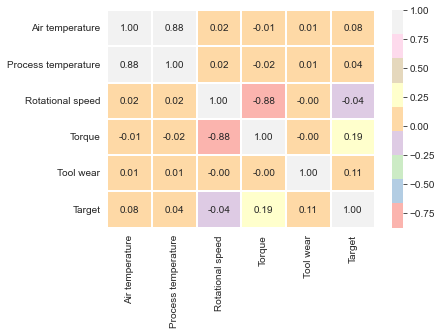

In [162]:
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='Pastel1',fmt='.2f',linewidth=0.1,linecolor='white')
plt.show()

#### Insights :
- Torque and Rotational speed are highly correlated
- Process Temperature and Air Temperature are highly correlated


<AxesSubplot:title={'center':'Rotational Speed vs Torque based on  Failure Type'}, xlabel='Rotational speed', ylabel='Torque'>

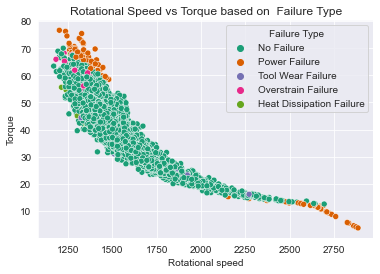

In [163]:
# fig, ax = plt.subplots(1,2, figsize=[22,8])
plt.title('Rotational Speed vs Torque based on  Failure Type')
sns.scatterplot(data=df, x='Rotational speed', y='Torque', hue='Failure Type',palette='Dark2') 
#Coloure reference here - https://www.kaggle.com/code/asimislam/python-colors-color-cmap-palette/notebook

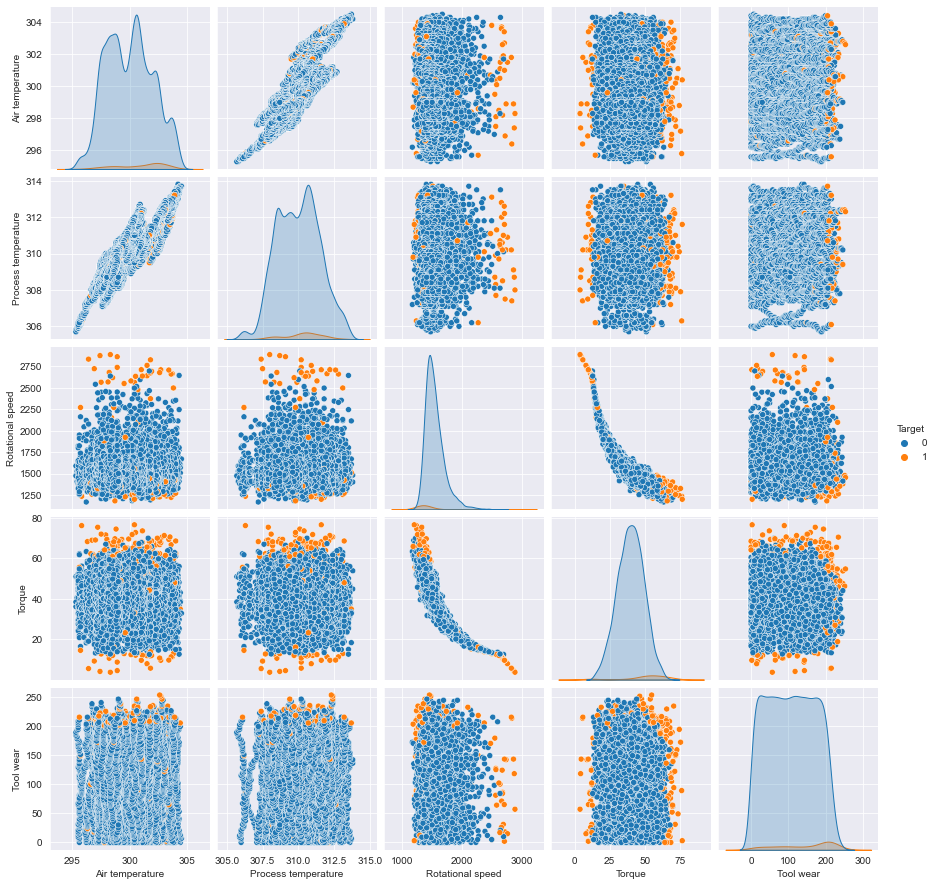

In [164]:
sns.pairplot(df, hue='Target')


#### Insight:
- It can be observed that the machines fail on extreme values of the variables. This is easily spotted in the graph since the orange dots are far apart for  features

/Users/viswatej/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Target', ylabel='count'>

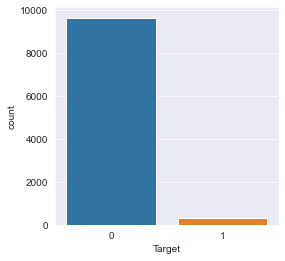

In [165]:
plt.figure(figsize=(4,4))
sns.countplot(df['Target'])

#### Insight :
- Highly Imbalanced Data

L    5984
M    2991
H     998
Name: Type, dtype: int64


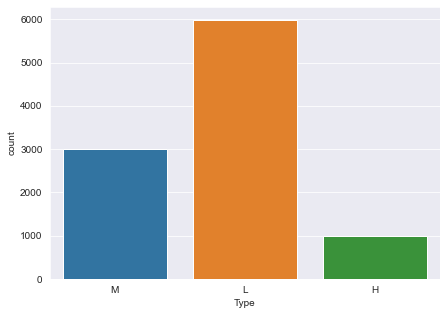

In [166]:
print(df['Type'].value_counts())
plt.figure(figsize=(7,5))
sns.countplot(data=df,x='Type')
plt.show()

<AxesSubplot:xlabel='Failure Type', ylabel='count'>

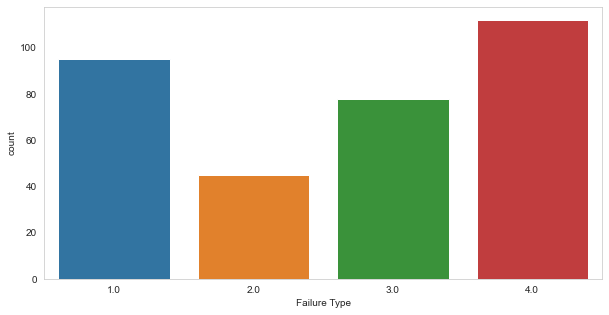

In [233]:
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['Target']==1],x="Failure Type")

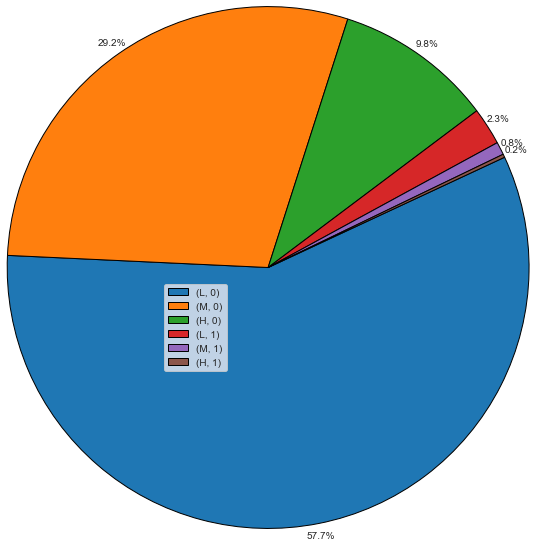

In [168]:
df[['Type','Target']].value_counts()[:10].plot(kind = 'pie', autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=False, startangle=25,labeldistance =None,
        pctdistance=1.05, radius=3).legend(loc='best')
# plt.legend(loc='lower right')

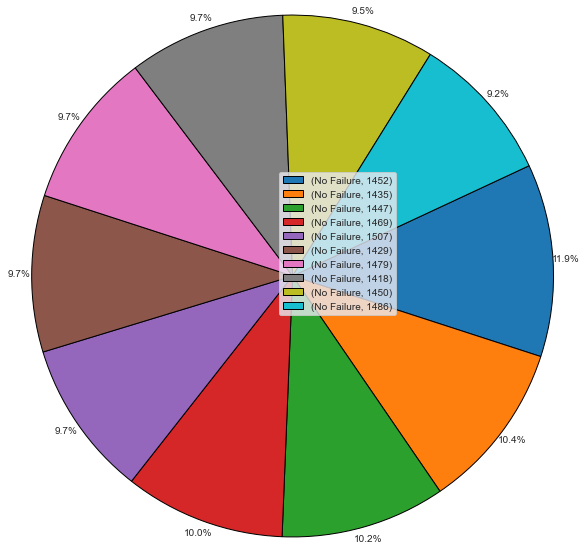

In [169]:
df[['Failure Type','Rotational speed']].value_counts()[:10].plot(kind = 'pie', autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=False, startangle=25,labeldistance =None,
        pctdistance=1.05, radius=3).legend(loc='best')
# plt.legend(loc='lower right')

#### Insights:
- L > M > H is the order of type of products failing  

In [170]:
print("skewness score")
df.skew(axis=0)

skewness score


/var/folders/lm/qkcrvy853g79ybtncmbrw98w0000gn/T/ipykernel_1008/3249271179.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew(axis=0)


Air temperature        0.115473
Process temperature    0.016186
Rotational speed       1.992859
Torque                -0.009719
Tool wear              0.028494
Target                 5.221459
dtype: float64

#### Insights:
- We can see that the Rotational speed is positively skewed

<AxesSubplot:xlabel='Rotational speed', ylabel='Count'>

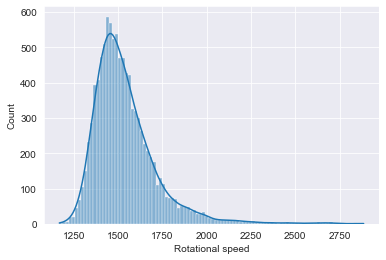

In [171]:
sns.histplot(df['Rotational speed'],kde=True)

<AxesSubplot:>

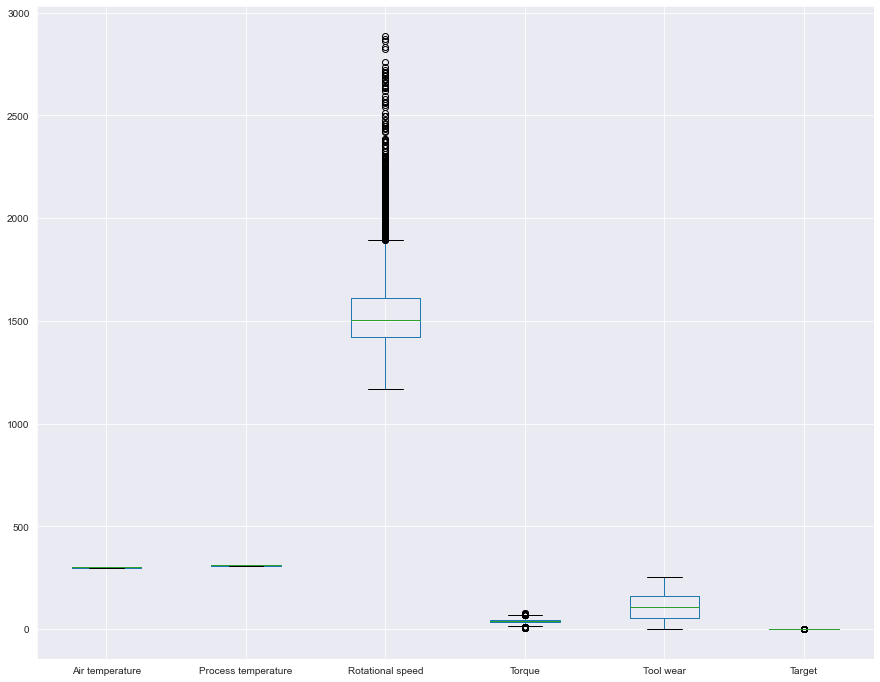

In [172]:
df.boxplot(figsize=(15,12))

In [173]:
Failure_type=df['Failure Type'].unique().tolist()

In [174]:
encoder = OrdinalEncoder(categories=[['L', 'M', 'H'], Failure_type])

encoded_data = encoder.fit_transform(df[['Type', 'Failure Type']])
encoded_data
df.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(encoded_data, 
                      index=df.index, 
                      columns=['Type', 'Failure Type'])


df = pd.concat([df, new_df], axis=1)

In [178]:
#Scaling the Data
df_scaled = df.copy()
# Scaling Rotational speed and torque with robust scaler as they have outliers in present:
columns = ['Rotational speed', 'Torque']
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled,features_scaled], axis=1)
df_scaled.head()

,Air temperature,Process temperature,Tool wear,Target,Type,Failure Type,Rotational speed,Torque
0,298.1,308.6,0,0,1.0,0.0,0.253968,0.200000
1,298.2,308.7,3,0,0.0,0.0,-0.502646,0.459259
2,298.1,308.5,5,0,0.0,0.0,-0.026455,0.688889
3,298.2,308.6,7,0,0.0,0.0,-0.370370,-0.044444
4,298.2,308.7,9,0,0.0,0.0,-0.502646,-0.007407


In [182]:
columns = ['Air temperature', 'Process temperature', 'Tool wear']
scaler = MinMaxScaler() # we have used minmax scaler as the data is not normally distrubuted.
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled, features_scaled], axis=1)
df_scaled.head()


,Target,Type,Failure Type,Rotational speed,Torque,Air temperature,Process temperature,Tool wear
0,0,1.0,0.0,0.253968,0.200000,0.304348,0.358025,0.000000
1,0,0.0,0.0,-0.502646,0.459259,0.315217,0.370370,0.011858
2,0,0.0,0.0,-0.026455,0.688889,0.304348,0.345679,0.019763
3,0,0.0,0.0,-0.370370,-0.044444,0.315217,0.358025,0.027668
4,0,0.0,0.0,-0.502646,-0.007407,0.315217,0.370370,0.035573


In [187]:
x = df_scaled.drop(['Target', 'Failure Type'], axis=1)
y = df_scaled['Target']

In [188]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7479, 6), (2494, 6), (7479,), (2494,))

In [218]:
import time 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,classification_report
classifier=[]  #to store the model names
imported_as=[] #to store the instances of the models

In [219]:
lr = LogisticRegression()  #creating instance
classifier.append('Logistic Regression')
imported_as.append('lr')

In [220]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
classifier.append('k Nearest Neighbours')
imported_as.append('knn')

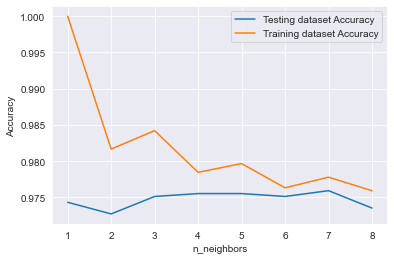

In [221]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(x_train, y_train)
    test_accuracy[i] = knn.score(x_test, y_test)
 
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy',)
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [222]:
knn = KNeighborsClassifier(n_neighbors=)
 
knn.fit(x_train, y_train)
 
# Calculate the accuracy of the model
print("KNN Model Accuracy - ",knn.score(x_test, y_test))

KNN Model Accuracy -  0.9759422614274258


In [223]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
classifier.append('Random Forest')
imported_as.append('rf')

In [224]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
dt = DecisionTreeClassifier()

classifier.append('Decision Tree')
imported_as.append('dt')

In [234]:
classifiers = pd.DataFrame({'Classifier':classifier,'Imported as':imported_as})
display(classifiers)


,Classifier,Imported as
0,Logistic Regression,lr
1,k Nearest Neighbours,knn
2,Random Forest,rf
3,Decision Tree,dt


In [227]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_time= []
       
        for i in self.models:
            start=time.time()
            if i == 'knn':
                accuracy = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    accuracy.append([accuracy_score(self.Y_test,predK),j])
                temp = accuracy[0]
                for m in accuracy:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            model_acc.append(accuracy_score(self.Y_test,i.predict(self.X_test)))
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
        self.models_output = pd.DataFrame({'Models':self.models,'Accuracy':model_acc,'Runtime (s)':model_time})
        
    def results(self):
        models=self.models_output
        models = models.sort_values(by=['Accuracy','Runtime (s)'],ascending=[False,True]).reset_index().drop('index',axis=1)
        self.best = models['Models'][0]
        models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
        models['Accuracy']=models['Accuracy'].round(5)*100
        self.models_output_cleaned=models
        return(models)
        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_accuracy(self):
        return(self.models_output_cleaned['Accuracy'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

In [228]:
models_to_test = [rf,lr,knn,dt]  #models we are testing

In [229]:
classification = Modelling(x_train,y_train,x_test,y_test,models_to_test) 
classification.fit()
classification.results()

RandomForestClassifier() has been fit
LogisticRegression() has been fit
KNeighborsClassifier(n_neighbors=7) has been fit
DecisionTreeClassifier() has been fit


,Models,Accuracy,Runtime (s)
0,RandomForestClassifier,98.677,0.499430
1,DecisionTreeClassifier,97.915,0.016882
2,KNeighborsClassifier,97.594,0.065874
3,LogisticRegression,97.233,0.028699


In [230]:
print('BestModel is:',  classification.best_model(type='name'))
print('Accuracy of model:',classification.best_model_accuracy())
print('Training Runtime in seconds',classification.best_model_runtime())
print('Classification Matrix:\n')
print(classification.best_model_clmatrix())

BestModel is: RandomForestClassifier
Accuracy of model: 98.677
Training Runtime in seconds 0.499
Classification Matrix:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2411
           1       0.93      0.65      0.77        83

    accuracy                           0.99      2494
   macro avg       0.96      0.82      0.88      2494
weighted avg       0.99      0.99      0.99      2494



/Users/viswatej/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


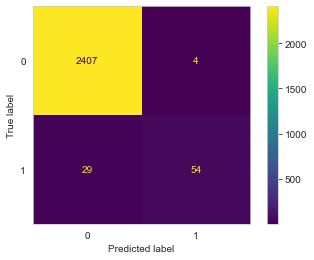

In [232]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
sns.set_style("whitegrid", {"grid.color": "1", "grid.linestyle": " "})
plot_confusion_matrix(classification.best_model(type='model'), x_test, y_test) 